In [1]:
%matplotlib inline
import bt

In [18]:
# download data
data = bt.get('aapl,msft,c,gs,ge', start='2010-01-01')

# calculate moving average DataFrame using pandas' rolling_mean
import pandas as pd
# a rolling mean is a moving average, right?
sma = data.rolling(50).mean()

In [9]:
#sma.columns = sma.columns.map(lambda col: col + ' MA(50)')

In [19]:
sma.tail(2)

,aapl,msft,c,gs,ge
Date,,,,,
2017-10-04,157.340500,73.455924,68.939757,226.20124,24.606525
2017-10-05,157.391105,73.502173,69.100824,226.69257,24.590588


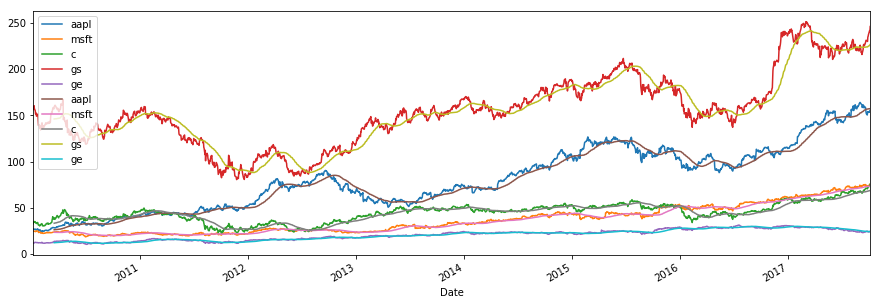

In [20]:
plot = bt.merge(data, sma).plot(figsize=(15, 5))

### SelectWhere parts

In [27]:
signal = data > sma

In [35]:
sig = signal.loc['2011-02-14']
sig

aapl     True
msft    False
c        True
gs       True
ge       True
Name: 2011-02-14 00:00:00, dtype: bool

In [37]:
list(sig.index)

['aapl', 'msft', 'c', 'gs', 'ge']

In [39]:
list(sig.index[sig]) # msft is filtered!

['aapl', 'c', 'gs', 'ge']

### SelectWhere

In [23]:
class SelectWhere(bt.Algo):
    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal
    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True

In [24]:
# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)

above50sma
0% [############################# ] 100% | ETA: 00:00:00

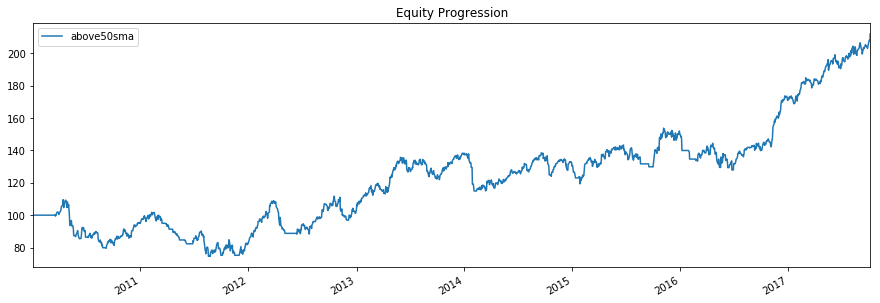

In [25]:
res.plot()

In [26]:
res.display()

Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2017-10-05
Risk-free rate       0.00%

Total Return         112.12%
Daily Sharpe         0.64
Daily Sortino        0.78
CAGR                 10.18%
Max Drawdown         -31.97%
Calmar Ratio         0.32

MTD                  2.95%
3m                   7.47%
6m                   15.52%
YTD                  24.12%
1Y                   49.12%
3Y (ann.)            16.06%
5Y (ann.)            14.73%
10Y (ann.)           10.18%
Since Incep. (ann.)  10.18%

Daily Sharpe         0.64
Daily Sortino        0.78
Daily Mean (ann.)    11.28%
Daily Vol (ann.)     17.72%
Daily Skew           -0.55
Daily Kurt           4.64
Best Day             5.78%
Worst Day            -7.99%

Monthly Sharpe       0.59
Monthly Sortino      0.79
Monthly Mean (ann.)  11.77%
Monthly Vol (ann.)   20.11%
Monthly Skew         -0.56
Monthly Kurt         0.76
Best Month           13.64%
Worst Month         